# Offline RL

Here we start by setting by the cart-pole domain from the Gym environment suite

In [192]:
!pip install gymnasium==0.27.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [193]:
import numpy as np
import gymnasium as gym
env = gym.make('CartPole-v1')

def observation2state(observation,bins):
    state = []
    for i in range(len(observation)):
        digit = np.digitize(observation[i],bins[i])
        state.append(digit)
    state = ''.join(str(digit) for digit in state)

    return int(state)

def action_selection(state,Q,n_action,epsilon):
    if np.random.random() < epsilon:
        action = np.random.randint(n_action)
    else:
        action = np.argmax(Q[state])
    return action

n_states = 4
n_actions = 2

#create the bins for each state by boundings tested before
x = np.linspace(-3,3,9)
cv = np.linspace(-4,4,9)
#cv = np.linspace(env.env.observation_space.low[1],env.env.observation_space.high[1],10)
a = np.linspace(-0.3,0.3,9)
av = np.linspace(-4,4,9)
#av = np.linspace(env.env.observation_space.low[3],env.env.observation_space.high[3],10)
bins = [x,cv,a,av]

Below is our preferred agent from Assignment 2 which we re-train.

It is a Q-learning agent with alpha=0.1 and gamma=0.1

In [194]:
def q_learning(env,seed,bins,alpha,epsilon,gamma = 0.95):
    ns = 10*10*10*10
    na = env.action_space.n
    np.random.seed(seed)
    #init weights in [-0.001,0.001]
    Q = np.random.rand(ns,na)/500-0.001
    n_episode = 5000
    rewards = [] 
    for episode in range(n_episode):
        observation = env.reset()[0]
        state = observation2state(observation,bins)
        done = False
        total_reward = 0
        
        while not done:
            action = action_selection(state,Q,na,epsilon)
            next_observation,reward,done,truncation,_ = env.step(action)
            if truncation:
                break
            total_reward += reward
            next_state = observation2state(next_observation,bins)
            #update Q value
            Q[state,action] += alpha*(reward+gamma*np.max(Q[next_state])-Q[state,action])
            state = next_state
        rewards.append(total_reward)

    return Q, rewards

Q_expert,r = q_learning(env,0,bins,0.1,0.1)

In [195]:
print(Q_expert.shape)
print(len(r))

(10000, 2)
5000


## Data Generation

We gather, in total, 500 behaviour episodes from our preferred agent. To do so, we incrementally adjust the epsilon ('greediness' factor) along 1.0, 0.5, and 0, as well as record the first 100, 250, then 500 episodes per epsilon 

Eventually, we also gather 500 behaviour episodes from a random agent.



In [196]:
def generate_data(agent,env,bins,episodes,percentage_expert):
    data_all = []
    na = env.action_space.n
    for i in range(int(episodes*percentage_expert)):
        data=[]
        observation = env.reset()[0]
        state = observation2state(observation,bins)
        action = action_selection(state,agent,na,0)
        data.append([state,action])
        done = False
        while not done:
            
            observation,_,done,truncation,_ = env.step(action)
            if truncation:
                break
            if (not done):
                state = observation2state(observation,bins)
                action = action_selection(state,agent,na,0)
                data.append([state,action])
        data_all.append(data)
    for i in range(int(episodes*(1-percentage_expert))):
        data=[]
        observation = env.reset()[0]
        state = observation2state(observation,bins)
        action = env.action_space.sample()
        data.append([state,action])
        done = False
        while not done:
            
            observation,_,done,truncation,_ = env.step(action)
            if truncation:
                break
            if (not done):
                state = observation2state(observation,bins)
                action = env.action_space.sample()
                data.append([state,action])
        data_all.append(data)
    return data_all

In [197]:
exp_p=[1,0.5,0]
ep = [100,150,250]
#generate data for episode = 100,250,500
data = [] 
for i in range(3):
  for j in range(3):
    if (j>0):
      data.append(np.concatenate((generate_data(Q_expert,env,bins,ep[j],exp_p[i]),data[i*3+j-1]),axis=0))
    else:
      data.append(generate_data(Q_expert,env,bins,ep[j],exp_p[i]))

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [198]:
print(len(data))

9


In [199]:
print(data[0][0][0])

[4544, 0]


Next, we compare two approaches:
*   Simple imitation learning: using logistic regression to imitate the
action observed in each state

*   Fitted Q-learning


## Simple Imitation Learning (Logistic Regression)

Here we train for each of the 9 datasets, yielding a separately optimized "agent" with a separately tuned "preferred" action for each state (4 categories, 10 bins per category), for each dataset. We then run each "agent" in a simulation of 100 episodes to record and later plot the mean and std reward.

We also try out 2 learning rates, a=0.05 and a=0.005

In [200]:
#for logistic regression
#using softmax to get probability
def softmax(x):
    p = np.array(x)
    n = np.exp(x).sum()
    for i in range(len(x)):
        p[i] = np.exp(x[i])/n
    return p

#compute cross entropy loss
def cross_entropy(x,y):
    p = softmax(x)
    l=0
    for i in range(len(x)):
      l += -y[i]*np.log(p[i])-(1-y[i])*np.log(1-p[i])
    l = l/len(x)
    return l

#gradients of the cross_entropy loss to every Q.
def gradient(x,y):
    r = np.array(x)
    n = np.exp(x).sum()
    p = softmax(x)
    r[0] = y[0]-p[0]
    r[1] = y[1]-p[1]
    return r

def action_selection_p(state,Q):
    action = np.argmax(softmax(Q[state]))
    return action

def log_reg_trainer(data,alpha,epoch):
  Q=np.random.rand(10000,2)/500-0.001
  for i in range(epoch):
    total_loss=0
    for episode in range(len(data)): # 100, 250, or 500
      loss = 0
      for s in range(len(data[episode])): # s
        action = data[episode][s][1]
        state = data[episode][s][0]

        y = np.zeros(2)
        y[action] = 1
        loss += cross_entropy(Q[state],y)
        
        Q[state] += alpha*gradient(Q[state],y)
      total_loss += loss/len(data[episode])
    print(total_loss/len(data))
  return Q

def test(agent,env,episode):
  rewards = [] 
  na = env.action_space.n
  for i in range(episode):
      observation = env.reset()[0]
      state = observation2state(observation,bins)
      done = False
      total_reward = 0
      while not done:
          action = action_selection_p(state,agent)
          observation,reward,done,truncation,_ = env.step(action)
          state = observation2state(observation,bins)
          total_reward+=reward
          if truncation:
              break
      rewards.append(total_reward)
  return rewards

In [201]:
#train for behaviour clone 

# LEARNING RATE 0.05 

Q_bc = []
for i in range(3):
  for j in range(3):
    Q = log_reg_trainer(data[i*3+j],0.05,1)
    Q_bc.append(Q)

rewards=[]
for i in range(3):
  for j in range(3):
    rewards.append(test(Q_bc[i*3+j],env,100))

print(np.std(rewards,axis=1))
print(np.mean(rewards,axis=1))

0.1122609496567266
0.05961364524316961
0.036953296742427554
0.571360667982765
0.5566805616278943
0.5282624836678141
0.6997082319677859
0.6994387753991254
0.6996593942929241
[39.85624167 35.79748595 40.84593003 31.14638181 35.01043273 43.49185096
 59.71396738 29.65973028 25.61244034]
[144.2  140.2  143.7  131.27 140.36 140.83  76.11  41.98  37.27]


In [202]:
Q_bc = []
for i in range(3):
  for j in range(3):
    Q = log_reg_trainer(data[i*3+j],0.005,1)
    Q_bc.append(Q)

rewards=[]
for i in range(3):
  for j in range(3):
    rewards.append(test(Q_bc[i*3+j],env,100))

print(np.std(rewards,axis=1))
print(np.mean(rewards,axis=1))

# [(1,100), (1,250), (1,500), 
# (0.5,100), (0.5,250), (0.5,500), 
# (0,100), (0,250), (0,500)]

0.3465882232510906
0.22339107471484015
0.15245781509421427
0.6060978418610085
0.5773220939454123
0.5741998274532853
0.6939904926536417
0.6939417561843365
0.69357233710468
[37.92663444 38.90020437 33.30222065 51.99304857 38.06267857 36.22984405
 35.36253809 69.87351072 54.37966072]
[147.48 140.71 139.39 145.27 145.95 141.72  52.97  66.45  61.55]


We know that the dataset is organized per (agent epsilon, episodes) as follows:

*   [(1,100), (1,250), (1,500), 
*   (0.5,100), (0.5,250), (0.5,500), 
*   (0,100), (0,250), (0,500)]

From above, we see that alpha = 0.005 generally outperforms alpha = 0.05, therefore we select the former as our preferred learning rate for LR. However, the difference is almost negligible from the results above.

We also observe that generally, as the dataset used for Offline RL relies less on the expert policy, the worse reward/performance we get. There is also no reliably observed relationship between number of episodes and offline performance/reward, however we would assume that with a great agent, there would be a positive relationship between the two. 

Below is a summary of how the list 'data' is organized.

In [203]:
print(str(len(data)) + ' datasets')
print(str(len(data[0])) + ' episodes')
print(str(len(data[0][0])) + ' steps' )
print(str(len(data[0][0][0])) + ' elements: state and action')
print(data[0][0][0])

9 datasets
100 episodes
117 steps
2 elements: state and action
[4544, 0]


## Fitted Q-Learning

We do the same for Fitted Q-Learning, which follows the steps below:
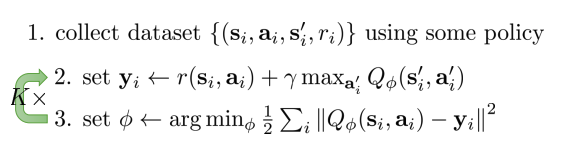

We will set K=15 in this experiment and test out 2 learning rates, a=0.05 and a=0.005.

In [211]:
def num2vec(state):
  num = str(state)
  vec = np.zeros((4,10))
  for i, dig in enumerate(num):
    dig = int(dig)
    vec[i, dig] = 1
  return vec

def q_gradient(phi, y, state, alpha):
  vec = num2vec(state)
  state = str(state)
  grad = alpha*(linear_fa(phi, vec)-y)
  for i, dig in enumerate(state):
    dig = int(dig)
    #print(alpha*linear_fa(phi, vec))
    phi[i][dig]+= grad
  return phi

def linear_fa(phi, state):
  a = 0 
  for i in range(phi.shape[0]):
    #print(phi[i])
    a += np.dot(phi[i], state[i])
  return a

In [212]:
def fitted_q_learning(data, alpha, gamma, K):
  phi_1 = (np.random.rand(4,10))
  phi_2 = (np.random.rand(4,10))
  for i in range(K):
    #print(i)
    total_loss = 0
    for episode in range(len(data)):
      loss = 0

      # STEP 2

      max_len = len(data[episode])
      grad_1 = np.zeros((4,10))
      grad_2 = np.zeros((4,10))

      for s in range(len(data[episode])): 
        action = data[episode][s][1]
        code = str(data[episode][s][0])
        state = num2vec(data[episode][s][0])

        if s < max_len-1:
          r = 1
          next_state = num2vec(data[episode][s+1][0]) # assuming current_action taken
          q_max = max(linear_fa(phi_1, next_state), linear_fa(phi_2, next_state))
          y_i = r + gamma * q_max # where gamma is discount factor
        else:
          y_i = 0 # bc termination + no next step

        if action==0:
          grad_1[0][int(code[0])] += y_i  
          grad_1[1][int(code[1])] += y_i 
          grad_1[2][int(code[2])] += y_i 
          grad_1[3][int(code[3])] += y_i 
        else:
          grad_2[0][int(code[0])] += y_i  
          grad_2[1][int(code[1])] += y_i 
          grad_2[2][int(code[2])] += y_i 
          grad_2[3][int(code[3])] += y_i   
      
      # STEP 3

    phi_1 += alpha * grad_1
    phi_2 += alpha * grad_2

  return phi_1, phi_2

In [216]:
def q_test(x,y,env,episode):
  rewards = [] 
  na = env.action_space.n
  for i in range(episode):
    observation = env.reset()[0]
    state = observation2state(observation,bins)
    done = False
    total_reward = 0
    while not done:
      if linear_fa(x,num2vec(state))>linear_fa(y,num2vec(state)):
        action=0
      else:
        action=1
      observation,reward,done,truncation,_ = env.step(action)
      state = observation2state(observation,bins)
      total_reward+=reward
      if truncation:
          break
    rewards.append(total_reward)
  return rewards

In [217]:
fql = []
for i in range(3):
  for j in range(3):
    x, y = fitted_q_learning(data[i*3+j], 0.005, 0.9, 15)
    fql.append([x,y])

q_rewards=[]
for i in range(3):
  for j in range(3):
    q_rewards.append(q_test(fql[i*3+j][0],fql[i*3+j][1],env,100))

print(np.std(q_rewards,axis=1))
print(np.mean(q_rewards,axis=1))

[41.73766165 38.97848637 42.53673236  0.74906609  0.8109254   0.7675285
  1.56345771 10.91920785  3.09735371]
[195.26 196.24 195.92   9.33   9.32   9.47  12.66  19.47  10.92]


In [218]:
fql = []
for i in range(3):
  for j in range(3):
    x, y = fitted_q_learning(data[i*3+j], 0.05, 0.9, 15)
    fql.append([x,y])

q_rewards=[]
for i in range(3):
  for j in range(3):
    q_rewards.append(q_test(fql[i*3+j][0],fql[i*3+j][1],env,100))

print(np.std(q_rewards,axis=1))
print(np.mean(q_rewards,axis=1))

[41.35214626 44.26128218 40.80421057  0.66603303  0.68556546  0.66475559
  3.42350697  2.84061613  3.94050758]
[204.   201.83 193.58   9.42   9.3    9.41  14.14  13.97  13.82]


Above, we observe that for Fitted Q-Learning, an alpha=0.05 proves to outperform an alpha=0.005 on all datasets. However, interestingly, we see that the offline performance drastically worsens as we rely less on the expert policy, whereas there seems to be not much difference in rewards along the number of episodes. We believe that this is definitely because of the nature of the linear function approximator Q_phi VS logistic regression. 

In particular, we suggest that compared to Logistic Regression, Fitted Q-Learning allows high accuracy early in training (hence the small amount of data required), but is not robust and performs poorly across more randomized performances. Logistic regression tends to "underfit", whereas Fitted Q-Learning tends to "overfit".

To better visualize this, we may refer to the bar plots below:

## Visualization

For each of the 3 barchart plots below, we will have 3 bars for LR, 3 bars for FQL, and 3 bars for MLP. Every bar will be trained on a dataset with 100% expert policy, one with 50% expert and 50% random, and one with 100% random. The horizontal lines represent the average reward for expert and the average reward for random agents respectively.

In [266]:
def find_mean(data, a):
  mean = 0
  lena = len(data[a])
  for ep in data[a]:
    mean += len(ep)-1
  return mean/lena

find_mean(data,0)

138.59

[147.48, 145.27, 52.97]
[204.0, 9.42, 14.14]
[9.38, 9.49, 9.32]


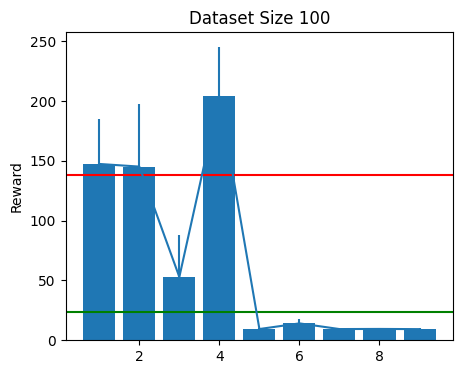

In [267]:
import matplotlib.pyplot as plt 

x=[1,2,3,4,5,6,7,8,9]

a = [x for i,x in enumerate(np.mean(rewards,axis=1)) if i%3==0]
astd = [x for i,x in enumerate(np.std(rewards,axis=1)) if i%3==0]
print(a)

b = [x for i,x in enumerate(np.mean(q_rewards,axis=1)) if i%3==0]
bstd = [x for i,x in enumerate(np.std(q_rewards,axis=1)) if i%3==0]
print(b)

c = [x for i,x in enumerate(np.mean(mlp_rewards,axis=1)) if i%3==0]
cstd = [x for i,x in enumerate(np.std(mlp_rewards,axis=1)) if i%3==0]
print(c)

y= np.concatenate((a,b))
y = np.concatenate((y,c))

yerr= np.concatenate((astd,bstd))
yerr= np.concatenate((yerr,cstd))

width = 5
height = 4
plt.figure(figsize=(width, height))
plt.bar(x, y)
plt.title('Dataset Size 100')
plt.ylabel('Reward')
plt.errorbar(x, y, yerr)
# agent mean
plt.axhline(y=find_mean(data,0), color='r')
# random mean
plt.axhline(y=find_mean(data,6), color='g')
plt.show()

[140.71, 145.95, 66.45]
[201.83, 9.3, 13.97]
[9.29, 9.23, 9.33]


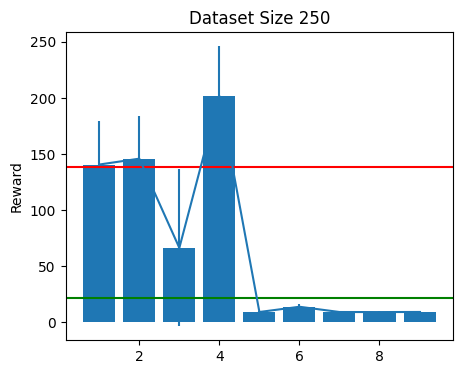

In [269]:
import matplotlib.pyplot as plt 

x=[1,2,3,4,5,6,7,8,9]

a = [x for i,x in enumerate(np.mean(rewards,axis=1)) if i%3==1]
astd = [x for i,x in enumerate(np.std(rewards,axis=1)) if i%3==1]
print(a)

b = [x for i,x in enumerate(np.mean(q_rewards,axis=1)) if i%3==1]
bstd = [x for i,x in enumerate(np.std(q_rewards,axis=1)) if i%3==1]
print(b)

c = [x for i,x in enumerate(np.mean(mlp_rewards,axis=1)) if i%3==1]
cstd = [x for i,x in enumerate(np.std(mlp_rewards,axis=1)) if i%3==1]
print(c)

y= np.concatenate((a,b))
y = np.concatenate((y,c))

yerr= np.concatenate((astd,bstd))
yerr= np.concatenate((yerr,cstd))

width = 5
height = 4
plt.figure(figsize=(width, height))
plt.bar(x, y)
plt.title('Dataset Size 250')
plt.ylabel('Reward')
plt.errorbar(x, y, yerr)
# agent mean
plt.axhline(y=find_mean(data,1), color='r')
# random mean
plt.axhline(y=find_mean(data,7), color='g')
plt.show()

[139.39, 141.72, 61.55]
[193.58, 9.41, 13.82]
[9.32, 9.32, 9.28]


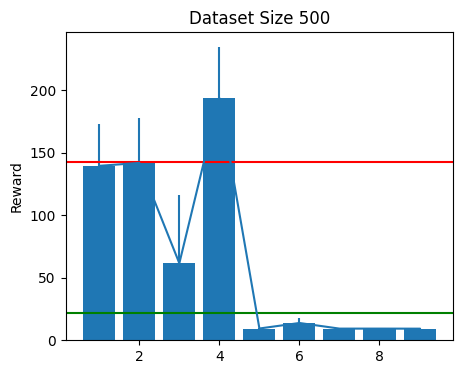

In [270]:
import matplotlib.pyplot as plt 

x=[1,2,3,4,5,6,7,8,9]

a = [x for i,x in enumerate(np.mean(rewards,axis=1)) if i%3==2]
astd = [x for i,x in enumerate(np.std(rewards,axis=1)) if i%3==2]
print(a)

b = [x for i,x in enumerate(np.mean(q_rewards,axis=1)) if i%3==2]
bstd = [x for i,x in enumerate(np.std(q_rewards,axis=1)) if i%3==2]
print(b)

c = [x for i,x in enumerate(np.mean(mlp_rewards,axis=1)) if i%3==2]
cstd = [x for i,x in enumerate(np.std(mlp_rewards,axis=1)) if i%3==2]
print(c)

y= np.concatenate((a,b))
y = np.concatenate((y,c))

yerr= np.concatenate((astd,bstd))
yerr= np.concatenate((yerr,cstd))

width = 5
height = 4
plt.figure(figsize=(width, height))
plt.bar(x, y)
plt.title('Dataset Size 500')
plt.ylabel('Reward')
plt.errorbar(x, y, yerr)
# agent mean
plt.axhline(y=find_mean(data,2), color='r')
# random mean
plt.axhline(y=find_mean(data,8), color='g')
plt.show()

Here, generally speaking, we observe that LR is more robust along epsilon, whereas FQL fits very well to the expert policy but is not able to generalize, as evidenced by its decrease as we rely more and more on exploration.

As mentioned above, this experiment suggests that the benefits of LR for Offline Learning would be on an expert agent that we are not fully confident of its performance across unknown data (bias-variance tradeoff), but we neverthelss want to get the most out of. On the other hand, FQL would be best used on agents that are confirmed to have robust and good performance, and where further exploration would not be necessary.

## Bonus: Multilayer Perceptron as Function Approximator

Here, for each state-action pair per datasaet, we create an entry in target matrix y following the formula as outlined in FQL above and fit the MLP to it. We do this K times, given the y matrix changes at every fit towards convergence.

In [238]:
def num2list (state):
  x = []
  state = str(state)
  for i in state:
    x.append(int(i))
  return x

In [242]:
from sklearn.neural_network import MLPRegressor

def fql_mlp(data, gamma, K):

  clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
  clf.fit(np.random.randint(10, size=(100,5)), np.random.rand(100,1))

  for i in range(K):
    print(i)
    x = []
    y = []

    for episode in range(len(data)):
      max_len = len(data[episode])

      for s in range(len(data[episode])):
        action = data[episode][s][1]
        state = num2list(data[episode][s][0])

        if s < max_len-1:
          r = 1
          next_state = num2list(data[episode][s+1][0]) 
          a = [i for i in next_state]
          a.append(0)

          b = [i for i in next_state]
          b.append(1)

          q_max = max(clf.predict(np.array(a).reshape(1,-1)), clf.predict(np.array(b).reshape(1,-1)))
          y_i = r + gamma * q_max 
        else:
          y_i = 0 

        act = [i for i in state]
        act.append(action)

        x.append(act)
        y.append(y_i)
    
    clf.fit(x,y)
  return clf

In [243]:
def mlp_test(clf,env,episode):

  rewards = [] 
  na = env.action_space.n
  for i in range(episode):
    observation = env.reset()[0]
    state = observation2state(observation,bins)
    done = False
    total_reward = 0
    while not done:
      state = num2list(state)

      a = [i for i in state]
      a.append(0)

      b = [i for i in state]
      b.append(1)

      if clf.predict(np.array(a).reshape(1,-1)) > clf.predict(np.array(b).reshape(1,-1)):
        action=0
      else:
        action=1

      observation,reward,done,truncation,_ = env.step(action)
      state = observation2state(observation,bins)
      total_reward+=reward

      if truncation:
          break

    rewards.append(total_reward)

  return rewards

In [246]:
mlp_rewards=[]
for i in range(3):
  for j in range(3):
    clf = fql_mlp(data[i*3+j], 0.9, 15)
    mlp_rewards.append(mlp_test(clf,env,100))

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepro

0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepro

0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5
6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


1


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


2


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


3


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


4


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


5


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


6


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


7


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


8


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


9


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


10


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


11


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


12


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


13


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


14


/usr/local/lib/python3.9/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
